# Assignment #3

## 2. Search engine 

### Libraries

In [2]:
import pandas as pd
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import pandas as pd
import os
import re
import requests
import numpy as np
import time
import folium
from folium import IFrame
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/onurozansunger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/onurozansunger/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Script to create a DataFrame for the courses using the TSV files 

In [3]:

# Path to the folder containing TSV files
folder_path = 'HW3/courses_tsv'

dfs = []

# Iterate over each file in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.tsv'):
        file_path = os.path.join(folder_path, file_name)
        
        # Read TSV file into a DataFrame
        df = pd.read_csv(file_path, sep='\t', header=None, names=[
            'courseName', 'universityName', 'facultyName', 'isItFullTime',
            'description', 'startDate', 'fees', 'modality', 'duration',
            'city', 'country', 'administration', 'url'
        ])
        
        # Append the DataFrame to the list
        dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
final_df = pd.concat(dfs, ignore_index=True)

# Write the DataFrame to a CSV file
final_df.to_csv('masters_csv', index=False)


In [4]:
df = pd.read_csv('masters_csv')
df.head()

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url
0,Future Manufacturing and Nanoscale Engineering...,University College London,Department of Mechanical Engineering,['Full Time'],Register your interest in graduate study at UC...,September,Please see the university website for further ...,MSc,1 year full time,London,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
1,Marketing - MSc,University of Bristol,Faculty of Social Sciences and Law,['Full Time'],"This programme, accredited by both the Charter...",September,Please see the university website for further ...,MSc,1 year full-time,Bristol,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
2,Global Management of Natural Resources MSc,University College London,Department of Chemical Engineering,['Full Time'],Register your interest in graduate study at UC...,September,"Full time - £21,200",MSc,1 year full time,London,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
3,Business Analytics MSc,University of Stirling,"Business, Management and Law","['Full Time', 'Part Time']",Business Analytics focuses on understanding th...,"September, January",Please see the university website for further ...,"PGCert,PGDip,MSc","12 months full-time, 24 months part-time",Stirling,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
4,Public Policy and Management MSc,King’s College London,King’s Business School,"['Full Time', 'Part Time']",Whether you are a social science graduate or a...,September,Please see the university website for further ...,MSc,"1 year FT, 2 years PT",London,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...


### Text Pre-processing

In [5]:
def preprocess_text(text):

    # Handling NaN/float values
    if not isinstance(text, str):
        return ''

    # Converting the text to lower case
    text = text.lower()

    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Breaking the text into words(tokens)
    words = nltk.word_tokenize(text)

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    # Joining the list of words to form the processed text
    processed_text = ' '.join(words)

    return processed_text

### Processing the fees column

##### Getting the currencies' USD exchange rates using fastforext API


In [6]:
url = 'https://api.fastforex.io/fetch-all'
headers = {
    'accept': 'application/json',
}

# Include the API key as a query parameter
params = {
    'api_key': '56359a1bde-e4fd75ffb0-s4bxgk',
}

# Make the GET request
response = requests.get(url, headers=headers, params=params)

# Check if the request was successful
if response.status_code == 200:
    exchange_rates = response.json()
    

else:
    print('An error has occurred.')

exchange_rates = exchange_rates['results']

first_10_items = list(exchange_rates.items())[:10]

for key, value in first_10_items:
    print(f'{key}: {value}')


AED: 3.67178
AFN: 69.23856
ALL: 94.12224
AMD: 401.63222
ANG: 1.78194
AOA: 824.36062
ARS: 356.47829
AUD: 1.52412
AWG: 1.79464
AZN: 1.69485


##### Function that retrieves the tuition fees and its currency and converts it to USD 

In [7]:
# List of currency symbols and their corresponding currency codes
currency_symbols = {
    'USD': '$',
    'EUR': '€',
    'GBP': '£',
    'JPY': '¥',
    'AUD': 'A$',
    'CAD': 'C$',
    'CHF': 'CHF',
    'CNY': '¥',
    'SEK': 'kr',
    'NZD': 'NZ$',
    'INR': '₹',
    'SGD': 'S$',
    'HKD': 'HK$',
    'NOK': 'kr',
    'KRW': '₩',
    'TRY': '₺',
    'ZAR': 'R',
    'BRL': 'R$',
    'RUB': '₽',
    'MXN': 'Mex$',
    'ARS': '$',
    'IDR': 'Rp',
    'MYR': 'RM',
    'PHP': '₱',
    'THB': '฿',
    'CZK': 'Kč',
    'HUF': 'Ft',
    'PLN': 'zł',
    'ISK': 'kr',
    'DKK': 'kr',
    'AED': 'د.إ',
    'SAR': '﷼',
    'QAR': '﷼',
    'EGP': 'EGP',
    'ILS': '₪',
    'KWD': 'د.ك',
    'BHD': 'ب.د',
    'OMR': 'ر.ع.',
    'JOD': 'د.ا',
    'LBP': 'ل.ل',
    'JMD': 'J$',
    'TTD': 'TT$',
    'COP': 'COL$',
    'CLP': 'CLP$',
    'PEN': 'S/',
    'UYU': '$U',
    'CRC': '₡',
}


def extract_and_convert_fees(row, exchange_rates):

    fees_usd = 0  
    
# Regex to find the tuition fees

    for currency, symbol in currency_symbols.items():

        regex = rf'{symbol}(\d+(?:,\d{{3}})*(\.\d+)?)'
        matches = re.findall(regex, row)

        for match in matches:

            # Remove commas and convert to float
            num = float(match[0].replace(',', ''))
            # Multiply by the conversion rate to get the amount in USD
            if currency in exchange_rates:
                num *= exchange_rates[currency]
                fees_usd = max(fees_usd, num)

    return fees_usd




### Applying text-preprocessing to the column 'description' and adding the column 'fees_USD'

In [8]:
df_updated = df.copy()
df_updated['description_lemmatized'] = df_updated['description'].apply(preprocess_text)
df_updated['fees_USD'] = df_updated['fees'].apply(lambda row: extract_and_convert_fees(str(row), exchange_rates) if not pd.isnull(row) else np.nan)
df_updated['fees_USD'] = df_updated['fees_USD'].round(2)

In [9]:
# Masters degrees with tuition fees mentioned in the scraped data
dummy = df_updated[df_updated['fees_USD'] != 0]
dummy.head(8)

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url,description_lemmatized,fees_USD
2,Global Management of Natural Resources MSc,University College London,Department of Chemical Engineering,['Full Time'],Register your interest in graduate study at UC...,September,"Full time - £21,200",MSc,1 year full time,London,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...,regist interest graduat studi uclmor ever grow...,16895.98
6,Construction Project Management - PgDip/PgCert...,Oxford Brookes University,School of the Built Environment,"['Full Time', 'Part Time', 'Online']",Our MSc in Construction Project Management (CP...,"September, January","Home (UK) full time - £10,800 Home (UK) part t...","PGDip,MSc,PGCert","1 year full time, 2 years part time (Sept star...",Oxford,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...,msc construct project manag cpm meet challeng ...,13150.17
10,Genes in Behaviour and Health (Research Master...,Vrije Universiteit Amsterdam,Faculty of Behavioural and Movement Sciences,['Full Time'],Nature and nurture: how do they interact and c...,September,"EU/EER Student: €2,209 NON-EU Student: €12,840","Research Only,MSc",2 years full time,Amsterdam,Netherlands,On Campus,https://www.findamasters.com/masters-degrees/c...,natur nurtur interact correl health wellb gene...,11758.49
12,MSc in Anthropology and Development Studies,Radboud University,Behavioural and Social Sciences,['Full Time'],How do grassroots initiatives by refugees impa...,September,The legal tuition for the 2024-2025 academic y...,MSc,1 year full time,Nijmegen,Netherlands,On Campus,https://www.findamasters.com/masters-degrees/c...,grassroot initi refuge impact upon practic pol...,16.00
13,International Real Estate and Planning MSc,University College London,The Bartlett School of Planning,"['Full Time', 'Part Time']",Register your interest in graduate study at UC...,September,"Full time - £18,000 Part time - £9,000",MSc,"1 year full time, 2 years part time, 5 years f...",London,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...,regist interest graduat studi uclthi programm ...,14345.64
19,MSc in Data Science & Artificial Intelligence ...,Emlyon Business School,Graduate Programmes,['Full Time'],ProgramThe aim of this program is to fill in t...,September,"€24,900 This tuition and fee charges are in ef...",MSc,18 months,Lyon,France,On Campus,https://www.findamasters.com/masters-degrees/c...,programth aim program fill gap busi engin high...,22802.67
26,Construction Management and International Deve...,University of Reading,School of Construction Management & Engineering,"['Full Time', 'Part Time']",Apply for this programmeExplore how building a...,September,"New UK/Republic of Ireland students: £12,550 ...",MSc,"1 year full time, 18-63 months flexible",Reading,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...,appli programmeexplor build infrastructur proj...,21478.61
31,Counterterrorism Risk Management and Resilienc...,Cranfield University,Cranfield Forensic Institute,"['Full Time', 'Part Time', 'Online']","OverviewThe MSc Counterterrorism, Risk Managem...",October,"• MSc Full-time £11,330 • MSc Part-time £11,33...","PGDip,PGCert,MSc",Part-time: 2 years (PgDip and PgCert) or 3 yea...,Bedford,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...,overviewth msc counterterror risk manag resili...,9029.78


### Conjunctive Querying

#### Creating the words vocabulary

In [10]:
# Create a vocabulary
vocabulary = set()

# Extract words from the 'description' column
for description in df_updated['description_lemmatized']:
     
     # Handling NaN/float values
     if isinstance(description, str):  
        words = description.split()
        vocabulary.update(words)

# Convert the vocabulary to a dictionary with words as keys and their index as values
vocabulary_dict = {idx: word for idx, word in enumerate(vocabulary)}

vocabulary_dict

{0: 'processingon',
 1: 'alipay',
 2: 'underwat',
 3: 'suscept',
 4: 'dissert',
 5: 'marketstripl',
 6: 'deficit',
 7: 'novic',
 8: 'dataset',
 9: 'midwiferi',
 10: 'various',
 11: 'ioh',
 12: 'wellresearch',
 13: 'biogeochemistryth',
 14: 'neurosciencerel',
 15: 'learnthrough',
 16: 'emiss',
 17: 'exceed',
 18: 'trajectori',
 19: 'palaeoclim',
 20: '90physic',
 21: 'disciplinari',
 22: 'fieldadv',
 23: 'recov',
 24: 'università',
 25: 'phdour',
 26: 'environmentonc',
 27: 'technicalbas',
 28: 'programthi',
 29: 'shock',
 30: 'contagion',
 31: 'economyand',
 32: 'esteem',
 33: 'median',
 34: 'breakdown',
 35: '650',
 36: 'businessman',
 37: 'fma',
 38: 'motor',
 39: 'crescendo',
 40: 'programmesinc',
 41: 'cognitioncours',
 42: 'assessmentlearn',
 43: 'bordercross',
 44: 'includingadvanc',
 45: 'extensivelyth',
 46: 'unit',
 47: 'concis',
 48: 'ukcric',
 49: 'marketfocu',
 50: 'besid',
 51: 'muchneed',
 52: 'princeton',
 53: 'coursean',
 54: 'twelv',
 55: 'approacheffect',
 56: '3dfigu

#### Creating the inverted index

In [11]:
# Create a dictionary to store word occurrences with row indices
result_dict = {word: [] for word in vocabulary}

# Iterate over rows to find occurrences
i = 0
for idx, description in enumerate(df_updated['description_lemmatized']):

    # Handling NaN/float values
    if isinstance(description, str):  
        words = description.split()
        for word in words:
            if word in vocabulary:
                result_dict[word].append(idx)
    
words_frequency = {}

for index, word in vocabulary_dict.items():
    if word in result_dict:
        words_frequency[index] = result_dict[word]

words_frequency

# Create a DataFrame from the dictionary
inverted_index = pd.DataFrame(list(result_dict.items()), columns=['word', 'documents_IDs'])
inverted_index['documents_IDs'] = inverted_index['documents_IDs'].apply(lambda x: list(set(x)))
inverted_index.to_csv('inverted_index.csv', index=False)
inverted_index.head()


,word,documents_IDs
0,processingon,[546]
1,alipay,[1849]
2,underwat,"[1061, 4615]"
3,suscept,[3311]
4,dissert,"[529, 2069, 2071, 1049, 538, 3100, 3613, 38, 4..."


In [12]:
inverted_index.shape

(14742, 2)

#### Function to process the search query

In [13]:
def execute_query(query, inverted_index, df):
    
    # Apply text preprocessing to the query
    processed_query = preprocess_text(query)

    query_words = processed_query.split()

    # Find document_IDs for each word in the query using the inverted index
    result_document_ids = []
    
    for word in query_words:

        if word in inverted_index['word'].values:

            # Get the document_IDs for the current word
            word_document_ids = inverted_index.loc[inverted_index['word'] == word, 'documents_IDs'].values[0]

            # Add the document_IDs to the result list
            result_document_ids.extend(word_document_ids)

    # Remove duplicate document_IDs
    result_document_ids = list(set(result_document_ids))
    result_document_ids.sort()
    
    # Return the rows corresponding to the document_IDs
    return df_updated.loc[result_document_ids, ['courseName', 'universityName', 'description', 'city', 'url']]

In [14]:
sample_query = 'advanced knowledge'
result = execute_query(sample_query, inverted_index, df_updated)
print(f'Number of results: {len(result)}')
result.head()



Number of results: 2491


,courseName,universityName,description,city,url
0,Future Manufacturing and Nanoscale Engineering...,University College London,Register your interest in graduate study at UC...,London,https://www.findamasters.com/masters-degrees/c...
1,Marketing - MSc,University of Bristol,"This programme, accredited by both the Charter...",Bristol,https://www.findamasters.com/masters-degrees/c...
4,Public Policy and Management MSc,King’s College London,Whether you are a social science graduate or a...,London,https://www.findamasters.com/masters-degrees/c...
6,Construction Project Management - PgDip/PgCert...,Oxford Brookes University,Our MSc in Construction Project Management (CP...,Oxford,https://www.findamasters.com/masters-degrees/c...
8,Construction Project Management with Industry ...,Heriot-Watt University,OverviewConstruction Project Management at Her...,Edinburgh,https://www.findamasters.com/masters-degrees/c...


### Conjunctive querying and Ranking Score

#### TF-IDF

In [15]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(vocabulary=inverted_index['word'].values)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_updated['description_lemmatized'])

# Convert the TF-IDF matrix to a DataFrame for better visualization
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=df_updated.index)
df_tfidf.head()

,processingon,alipay,underwat,suscept,dissert,marketstripl,deficit,novic,dataset,midwiferi,...,fouryear,copyright,likeprogrammingfinanci,nanodevic,consum,explorationit,20,roboadvisori,stellenbosch,infrastructuregradu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Creating the new inverted index
inverted_index_tfidf = inverted_index.copy()

# create a new column to store the document-tfidf pairs to match the format required
inverted_index_tfidf['documents_tfidf_pairs'] = inverted_index_tfidf.word.apply(lambda word: [(doc_id, df_tfidf.loc[doc_id, word]) for doc_id in df_tfidf.index if df_tfidf.loc[doc_id, word] > 0])
inverted_index_tfidf.head()

,word,documents_IDs,documents_tfidf_pairs
0,processingon,[546],"[(546, 0.2767471758145058)]"
1,alipay,[1849],"[(1849, 0.2350347613789217)]"
2,underwat,"[1061, 4615]","[(1061, 0.20179371165774182), (4615, 0.1711729..."
3,suscept,[3311],"[(3311, 0.21399679275944894)]"
4,dissert,"[529, 2069, 2071, 1049, 538, 3100, 3613, 38, 4...","[(38, 0.0971298811704156), (42, 0.081271170532..."


##### Function that executes the query by applying cosine similarity 

In [17]:
def execute_query_modified(query, inverted_index_tfidf, df, df_tfidf, tfidf_vectorizer):

    # Preprocess the query
    query_words = preprocess_text(query).split()

    # Find related documents
    related_docs = set.intersection(*(
        set(id for id, _ in inverted_index_tfidf.loc[inverted_index_tfidf['word'] == word, 'documents_tfidf_pairs'].iloc[0])
        for word in query_words
        if word in inverted_index_tfidf['word'].values
    ))

    # Return an empty DataFrame if no related documents were found
    if not related_docs:
        return pd.DataFrame()

    # Calculate cosine similarity for each document
    query_vectorized = tfidf_vectorizer.transform([' '.join(query_words)])
    similarities = {id: cosine_similarity(query_vectorized, df_tfidf.loc[id].values.reshape(1, -1))[0][0] for id in related_docs}

    # Sort documents by their similarity score
    sorted_doc_ids = sorted(similarities, key=similarities.get, reverse=True)

    output = df.loc[sorted_doc_ids, ['courseName', 'universityName', 'description', 'city', 'fees_USD', 'url']]
    output['similarity'] = [similarities[id] for id in sorted_doc_ids]

    return output.reset_index(drop=True)


##### Executing the function using the query "advanced knowledge"

In [18]:
query = 'advanced knowledge'
query_result = execute_query_modified(query, inverted_index_tfidf, df_updated, df_tfidf, tfidf_vectorizer).head(15)
query_result



,courseName,universityName,description,city,fees_USD,url,similarity
0,Advanced Computing MSc,King’s College London,Our Advanced Computing MSc provides knowledge ...,London,0.00,https://www.findamasters.com/masters-degrees/c...,0.394639
1,Advancing Practice - MSc,University of Northampton,Our MSc Advancing Practice awards support the ...,Northampton,0.00,https://www.findamasters.com/masters-degrees/c...,0.380455
2,Advanced Healthcare Practice - MSc,Cardiff University,Why study this courseOur MSc Advanced Healthca...,Cardiff,0.00,https://www.findamasters.com/masters-degrees/c...,0.379754
3,Advanced Clinical Practice - MSc,Canterbury Christ Church University,Gain the knowledge and skills needed to become...,Canterbury,1283.14,https://www.findamasters.com/masters-degrees/c...,0.359401
4,Advanced Mechanical Engineering - MSc (Eng),University of Leeds,This course offers a broad range of advanced s...,Leeds,24706.38,https://www.findamasters.com/masters-degrees/c...,0.337821
5,Advanced Biomedical Engineering - MSc,University of Bradford,Biomedical engineering is a fast evolving inte...,Bradford,0.00,https://www.findamasters.com/masters-degrees/c...,0.316692
6,Advanced Clinical Practice - MSc,University of Northampton,Our MSc Advanced Clinical Practice course aims...,Northampton,0.00,https://www.findamasters.com/masters-degrees/c...,0.311848
7,Advanced Professional Practice (MSc),University of Gloucestershire,Our lecturers are research active experts who ...,Gloucester,0.00,https://www.findamasters.com/masters-degrees/c...,0.311319
8,Advanced Computing - MSc,University of the West of Scotland,Our MSc Advanced Computing course is designed ...,Glasgow,0.00,https://www.findamasters.com/masters-degrees/c...,0.305071
9,Advanced Clinical Practice (AHP) - MSc/PGDip/P...,Bangor University,The programme has been developed to enhance pr...,Bangor,0.00,https://www.findamasters.com/masters-degrees/c...,0.299051


## 3. Define a new score!

Adding a new Dataframe to our existing one to write a scoring function.

In [19]:
qs_path = '2024 QS World University Rankings 1.1 (For qs.com).csv'
qs_df = pd.read_csv(qs_path)
qs_df.head()

,2024 RANK,2023 RANK,Institution Name,Country Code,Country,SIZE,FOCUS,RES.,AGE,STATUS,...,International Faculty Rank,International Students Score,International Students Rank,International Research Network Score,International Research Network Rank,Employment Outcomes Score,Employment Outcomes Rank,Sustainability Score,Sustainability Rank,Overall SCORE
0,1,1,Massachusetts Institute of Technology (MIT),US,United States,M,CO,VH,5.0,B,...,56,88.2,128,94.3,58,100.0,4,95.2,51,100.0
1,2,2,University of Cambridge,UK,United Kingdom,L,FC,VH,5.0,A,...,64,95.8,85,99.9,7,100.0,6,97.3,33=,99.2
2,3,4,University of Oxford,UK,United Kingdom,L,FC,VH,5.0,A,...,110,98.2,60,100.0,1,100.0,3,97.8,26=,98.9
3,4,5,Harvard University,US,United States,L,FC,VH,5.0,B,...,210,66.8,223,100.0,5,100.0,1,96.7,39,98.3
4,5,3,Stanford University,US,United States,L,FC,VH,5.0,B,...,78,51.2,284,95.8,44,100.0,2,94.4,63,98.1


Matching the collumn names on dataframes.

In [20]:
if 'fees_USD' in dummy.columns:
    # Replace 'fees' column in df_updated with 'fees_USD' column from dummy
    df_updated['fees'] = dummy['fees_USD']

In [21]:
df_updated = df_updated.merge(qs_df, left_on='universityName', right_on='Institution Name', how='left')

In [22]:
# Dropping columns from df_updated
columns_to_drop = ['Academic Reputation Rank', 'Employer Reputation Rank','Faculty Student Rank','Faculty Student Rank', 'Citations per Faculty Rank', 'International Faculty Rank', 'International Students Rank', 'International Research Network Rank', 'Employment Outcomes Rank',  'Sustainability Rank', 'Overall SCORE']
df_updated = df_updated.drop(labels=columns_to_drop, axis=1)

In [23]:
df_updated.head()

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,...,STATUS,Academic Reputation Score,Employer Reputation Score,Faculty Student Score,Citations per Faculty Score,International Faculty Score,International Students Score,International Research Network Score,Employment Outcomes Score,Sustainability Score
0,Future Manufacturing and Nanoscale Engineering...,University College London,Department of Mechanical Engineering,['Full Time'],Register your interest in graduate study at UC...,September,NaN,MSc,1 year full time,London,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Marketing - MSc,University of Bristol,Faculty of Social Sciences and Law,['Full Time'],"This programme, accredited by both the Charter...",September,NaN,MSc,1 year full-time,Bristol,...,A,74.9,84.7,47.3,64.7,85.5,86.8,84.4,39.6,81.3
2,Global Management of Natural Resources MSc,University College London,Department of Chemical Engineering,['Full Time'],Register your interest in graduate study at UC...,September,16895.98,MSc,1 year full time,London,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Business Analytics MSc,University of Stirling,"Business, Management and Law","['Full Time', 'Part Time']",Business Analytics focuses on understanding th...,"September, January",NaN,"PGCert,PGDip,MSc","12 months full-time, 24 months part-time",Stirling,...,A,11.5,10.2,10.5,34.7,71.9,83.5,14.4,14.8,79.8
4,Public Policy and Management MSc,King’s College London,King’s Business School,"['Full Time', 'Part Time']",Whether you are a social science graduate or a...,September,NaN,MSc,"1 year FT, 2 years PT",London,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# print all column names (factors) of the DataFrame
print(df_updated.columns.tolist())

['courseName', 'universityName', 'facultyName', 'isItFullTime', 'description', 'startDate', 'fees', 'modality', 'duration', 'city', 'country', 'administration', 'url', 'description_lemmatized', 'fees_USD', '2024 RANK', '2023 RANK', 'Institution Name', 'Country Code', 'Country', 'SIZE', 'FOCUS', 'RES.', 'AGE', 'STATUS', 'Academic Reputation Score', 'Employer Reputation Score', 'Faculty Student Score', 'Citations per Faculty Score', 'International Faculty Score', 'International Students Score', 'International Research Network Score', 'Employment Outcomes Score', 'Sustainability Score']


So far we removed the unnecessery collumns and removed the Overal Score collumn (because we will define our own scoring function). Now lets start on scoring function.

In [25]:
def calculate_score(document, query):
    score = 0

    # Weights for different components
    academic_weight = 0.15
    employer_weight = 0.15
    international_faculty_weight = 0.1
    international_students_weight = 0.1
    citations_weight = 0.1
    textual_relevance_weight = 0.4

    # Academic and Employer Reputation
    if not pd.isnull(document['Academic Reputation Score']):
        score += float(document['Academic Reputation Score']) / 100 * academic_weight
    if not pd.isnull(document['Employer Reputation Score']):
        score += float(document['Employer Reputation Score']) / 100 * employer_weight

    # International Faculty and Students Scores
    if not pd.isnull(document['International Faculty Score']):
        score += float(document['International Faculty Score']) / 100 * international_faculty_weight
    if not pd.isnull(document['International Students Score']):
        score += float(document['International Students Score']) / 100 * international_students_weight

    # Citations per Faculty
    if not pd.isnull(document['Citations per Faculty Score']):
        score += float(document['Citations per Faculty Score']) / 100 * citations_weight

    # Textual Relevance
    query_terms = set(query.lower().split())
    description_terms = set(document['description_lemmatized'].lower().split())
    common_terms = query_terms.intersection(description_terms)
    score += len(common_terms) / len(query_terms) * textual_relevance_weight

    # Normalization based on the total weights
    total_weight = academic_weight + employer_weight + international_faculty_weight + international_students_weight + citations_weight + textual_relevance_weight
    normalized_score = (score / total_weight) * 100  # Normalized to be out of 100

    return min(normalized_score, 100)  # Ensuring the score doesn't exceed 100

Re-Creating the inverted index

In [26]:
# Create a dictionary to store word occurrences with row indices
result_dict = {word: [] for word in vocabulary}

# Iterate over rows to find occurrences
i = 0
for idx, description in enumerate(df_updated['description_lemmatized']):

    # Handling NaN/float values
    if isinstance(description, str):  
        words = description.split()
        for word in words:
            if word in vocabulary:
                result_dict[word].append(idx)
    
words_frequency = {}

for index, word in vocabulary_dict.items():
    if word in result_dict:
        words_frequency[index] = result_dict[word]

words_frequency

# Create a DataFrame from the dictionary
inverted_index = pd.DataFrame(list(result_dict.items()), columns=['word', 'documents_IDs'])
inverted_index['documents_IDs'] = inverted_index['documents_IDs'].apply(lambda x: list(set(x)))
inverted_index.to_csv('inverted_index.csv', index=False)
inverted_index.head()


,word,documents_IDs
0,processingon,[546]
1,alipay,[1849]
2,underwat,"[1061, 4615]"
3,suscept,[3311]
4,dissert,"[529, 2069, 2071, 1049, 538, 3100, 3613, 38, 4..."


Now we will add the similarity score calculation (using jaccard similarity) and sorting the master courses in our dataframe regarding on similarity scores and overall scores.

In [27]:
# Define the preprocess_text function
def preprocess_text(text):
    
    # Handling NaN/float values
    if not isinstance(text, str):
        return ''

    # Converting the text to lower case
    text = text.lower()

    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Breaking the text into words(tokens)
    words = nltk.word_tokenize(text)

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    # Joining the list of words to form the processed text
    processed_text = ' '.join(words)

    return processed_text

# Function to calculate Jaccard similarity score
def calculate_jaccard_similarity(query_terms, document_terms):
    intersection = query_terms.intersection(document_terms)
    union = query_terms.union(document_terms)
    if len(union) == 0:
        return 0
    return len(intersection) / len(union)

# Execute_query function
def execute_query(query, inverted_index, df):
    # Apply text preprocessing to the query
    processed_query = preprocess_text(query)
    query_words = processed_query.split()

    # Find document_IDs for each word in the query using the inverted index
    result_document_ids = []
    for word in query_words:
        if word in inverted_index['word'].values:
            # Retrieve and flatten the list of document IDs
            word_document_ids = inverted_index.loc[inverted_index['word'] == word, 'documents_IDs'].explode().tolist()
            result_document_ids.extend(word_document_ids)

    # Remove duplicate document_IDs and sort
    result_document_ids = sorted(set(result_document_ids))

    # Retrieve the rows corresponding to the document_IDs
    relevant_docs = df.loc[result_document_ids]

    # Process the descriptions and calculate similarity scores
    relevant_docs['processed_description'] = relevant_docs['description_lemmatized'].apply(preprocess_text)
    query_terms_set = set(processed_query.split())
    relevant_docs['similarity_score'] = relevant_docs['processed_description'].apply(
        lambda doc: calculate_jaccard_similarity(query_terms_set, set(doc.split()))
    )

    # Calculate relevance scores for each document
    relevant_docs['relevance_score'] = relevant_docs.apply(lambda doc: calculate_score(doc, query), axis=1)

    # Sort documents first by relevance score, then by similarity score
    sorted_results = relevant_docs.sort_values(by=['relevance_score', 'similarity_score'], ascending=[False, False])

    # Filter out additional courses from the same university, keeping only the most relevant one
    most_relevant_per_university = sorted_results.drop_duplicates(subset='universityName')

    # Select specific columns for the final output
    final_columns = ['courseName', 'universityName', 'description', 'url', 'fees_USD', 'city', 'similarity_score', 'relevance_score']
    final_results = most_relevant_per_university[final_columns]

    return final_results

In [28]:
sample_query = 'advanced knowledge'
result = execute_query(sample_query, inverted_index, df_updated)
print(f'Number of results: {len(result)}')
result.head()

Number of results: 253


,courseName,universityName,description,url,fees_USD,city,similarity_score,relevance_score
468,Advanced Computational Methods for Aeronautics...,Imperial College London,This programme is suitable for applicants who ...,https://www.findamasters.com/masters-degrees/c...,0.0,London,0.042553,59.055
4473,MSc in Software Engineering,University of Oxford,The MSc in Software Engineering teaches the pr...,https://www.findamasters.com/masters-degrees/c...,0.0,Oxford,0.034483,58.700
3034,Doctor of Public Health,Harvard University,﻿Learn to translate knowledge into powerful re...,https://www.findamasters.com/masters-degrees/c...,0.0,Boston,0.062500,55.140
5189,MA/PGDip Heritage Studies,The University of Manchester,Course descriptionOur MA Heritage Studies mast...,https://www.findamasters.com/masters-degrees/c...,0.0,Manchester,0.025641,53.210
3983,Master of Science/Postgraduate Diploma in Envi...,The Hong Kong University of Science and Techno...,The program is meant to meet the needs of prac...,https://www.findamasters.com/masters-degrees/c...,0.0,Clear Water Bay,0.066667,47.935


## 4. Master's Degrees visualization map

In [29]:
# function to get the coordinates and country of a list of cities
def get_city_country_with_coordinates(cities):
    # Dictionary to store cities and their coordinates and countries
    city_country_coordinates = {}

    for city in cities:
        # Geolocator instance
        geolocator = Nominatim(user_agent="my_geocoder")
        location = geolocator.geocode(city)

        if location:
            city_coordinates = (location.latitude, location.longitude)
            country = location.address.split(",")[-1].strip()
            city_country_coordinates[city] = (city_coordinates, country)

        else:
            # If the city is not found, set the coordinates to None
            city_country_coordinates[city] = (None, "")
        
        time.sleep(1)

    return city_country_coordinates

In [30]:
# list of all the cities
cities = set(df_updated['city'].values)
# dictionary of cities and their coordinates and countries
city_country_coordinates = get_city_country_with_coordinates(cities)

In [31]:
# Create a DataFrame
df_city_country_coordinates = pd.DataFrame(list(city_country_coordinates.items()), columns=['City', 'Data'])

# Split the 'Data' column into 'Coordinates' and 'Country'
df_city_country_coordinates[['Coordinates', 'Country']] = pd.DataFrame(df_city_country_coordinates['Data'].tolist(),
                                                                        index=df_city_country_coordinates.index)

# Drop the original 'Data' column
df_city_country_coordinates = df_city_country_coordinates.drop('Data', axis=1)

df_city_country_coordinates.head()

,City,Coordinates,Country
0,NaN,"(46.3144754, 11.0480288)",Italia
1,Wolverhampton,"(52.5847651, -2.127567)",United Kingdom
2,Bergen,"(60.3943055, 5.3259192)",Norge
3,The Hague,"(52.07494555, 4.2696802205364515)",Nederland
4,Los Angeles,"(34.0536909, -118.242766)",United States


In [32]:
def create_map(df_city_country_coordinates, query_result):
    # Create a map centered around the first city in the coordinates dataframe
    map_center = df_city_country_coordinates['Coordinates'].iloc[0]
    my_map = folium.Map(location=map_center, zoom_start=2)

    # Add markers for each city in the query result dataframe
    for city_info in query_result['city'].unique():
        # Get the coordinates and country for the current city
        city_data = df_city_country_coordinates.loc[
            df_city_country_coordinates['City'] == city_info]
        city_coordinates = city_data['Coordinates'].values[0]
        city_country = city_data['Country'].values[0]

        # Get master courses information for the current city
        city_courses = query_result[query_result['city'] == city_info]

        # Create a label for the marker with master courses information
        label = f'<link rel="stylesheet" type="text/css" href="styles.css">'  # Link to external CSS
        label += f'<h4 style="text-align:center;">{city_info}, {city_country}</h4><br>'
        for index, course in city_courses.iterrows():
            label += f'<p><b>Course:</b> {course["courseName"]}</p>'
            label += f'<p><b>University:</b> {course["universityName"]}</p>'
            
            # Separate fees information
            fees_text = f'<p><b>Tuition in USD:</b> ${course["fees_USD"]:.2f}</p>' if course["fees_USD"] != 0.00 else \
                        f'<p><b>Tuition in USD:</b> Visit the website</p>'
            label += f'{fees_text}'

            # Separate URL information
            url_text = f'<p><b>URL:</b> <a href="{course["url"]}" target="_blank">{course["url"]}</a></p>'
            label += f'{url_text}<br><br>'

        # Create and add the marker to the map
        iframe = IFrame(html=label, width=500, height=500)
        popup = folium.Popup(iframe, max_width=500)
        folium.Marker(location=city_coordinates, popup=popup).add_to(my_map)

    # Display the map in the notebook
    display(my_map)


In [33]:
# Example usage
create_map(df_city_country_coordinates, query_result)

#### Map guide

- This tool provides students with an enhanced visualization of the geographical locations of the master's degree programs they are searching for.

- The map displays location icons on cities that host the master's degree programs of interest to the student.

- Upon clicking a location icon, a pop-up tab appears, presenting detailed information about the master's degree program. This includes the course name, university name, tuition fees in USD, and a clickable URL leading to the official website of the master's degree program.

## Command Line Question

As done in the previous assignment, we encourage using the command as a feature that Data Scientists must master.

Note: To answer the question in this section, you must strictly use command line tools. We will reject any other method of response. The final script must be placed in CommandLine.sh.

First, take the course_i.tsv files you created in point 1 and merge them using Linux commands (Hint: make sure that the first row containing the column names appears only once).

Now that you have your merged file named merged_courses.tsv, use Linux commands to answer the following questions:

Which country offers the most Master's Degrees? Which city?
How many colleges offer Part-Time education?
Print the percentage of courses in Engineering (the word "Engineer" is contained in the course's name).
Important note: You may work on this question in any environment (AWS, your PC command line, Jupyter notebook, etc.), but the final script must be placed in CommandLine.sh, which must be executable. Please run the script and include a screenshot of the output in the notebook for evaluation.

Script Purpose

The script is designed to merge data from multiple TSV (Tab-Separated Values) files into a single file and then perform specific analyses on the merged data. The analyses include finding which country and city offer the most Master's Degrees, counting how many colleges offer Part-Time education, and calculating the percentage of courses related to Engineering.

Script Breakdown

Setting Up the Environment

In [2]:
#!/bin/bash

This line indicates that the script should be run using the Bash shell, a common command-line interpreter.

These lines set the working directory to the folder containing the TSV files and then change to that directory.

Initializing the Merged File:

This command creates (or clears, if it already exists) a file named merged_courses.tsv. This file will be used to store the merged data.

Merging Data from Individual Files

This loop iterates over file names from course_0.tsv to course_5999.tsv.

For each file, it checks if the file exists (-f "$FILE").

If the file exists, it takes the first line from each file (head -n 1 "$FILE") and appends it to merged_courses.tsv. This is done because the data of interest is in the header line of each file.


Data Analysis

The script performs several analyses on the merged data:

1. Find the Country with the Most Master's Degrees:

Method: Utilizes awk to filter rows where the degree type column matches "MSc".

Process: Sorts and counts occurrences by country.

Output: Displays the country with the highest count.

2. Find the City with the Most Master's Degrees:

Method: Similar to the country analysis, but focuses on cities.

Process: Sorts and counts occurrences by city.

Output: Shows the city with the most Master's Degrees.

3. Count Colleges Offering Part-Time Education:

Method: Filters rows where the education mode column matches "Part Time".

Process: Counts unique college names that offer part-time education.

Output: Provides the total number of colleges offering part-time education.

4. Calculate the Percentage of Engineering Courses:

Method: Counts the total number of courses and the number of courses with "Engineering" or "Engineer" in their names.

Process: Calculates the percentage of engineering courses in relation to the total course count.

Output: Shows the percentage of engineering courses.

Output Results

The script concludes by echoing the results of the analyses to the console, providing insights into the dataset's contents in terms of degree types, education modes, and course subjects.

Full script:

Screenshot:

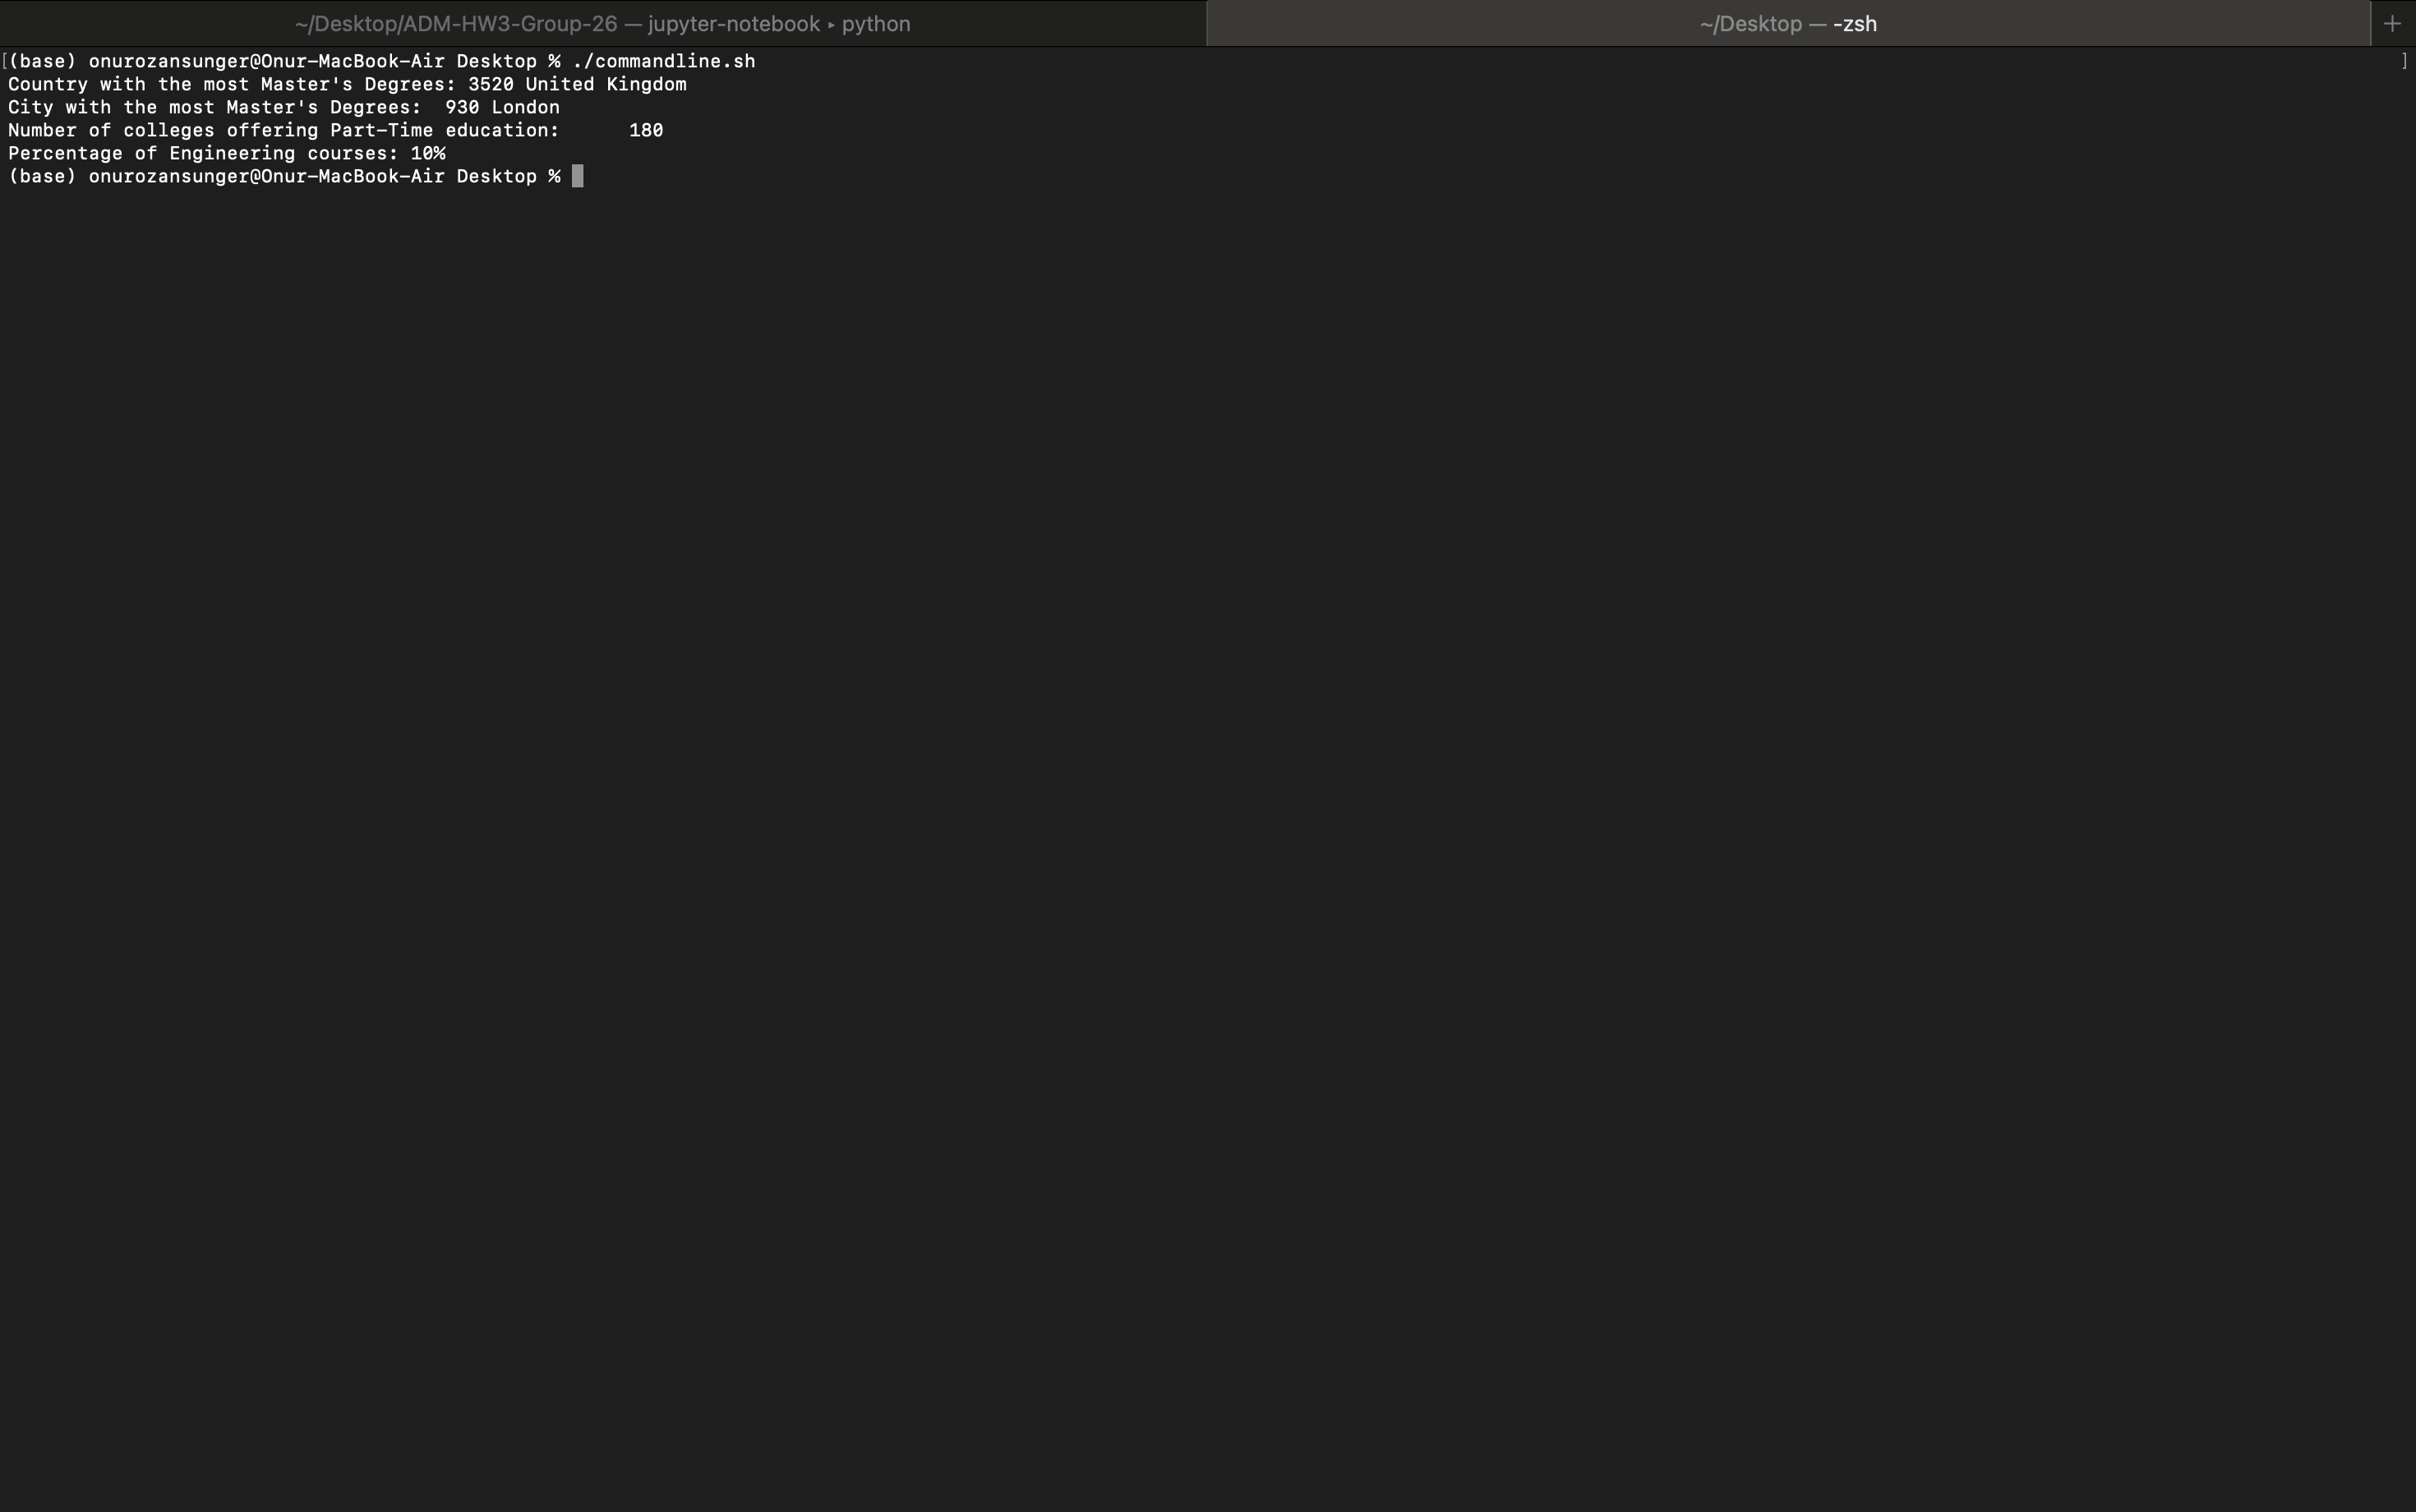


## Algorithmic Question

1. **Implement a code to solve the above mentioned problem.**

In [ ]:
sol_found = False

def reports_generation(list_hours, sumHours, partial_solution=[], idx=0, report=[]):
    global sol_found

    #Stop if a solution is found
    if sol_found:
        return

    if idx == len(list_hours):
        if sum(partial_solution) == sumHours:
            report.append(partial_solution.copy())
            sol_found = True
        return

    for element in list_hours[idx]:
        partial_solution.append(element)
        #Prune the partial solutions with an amount of hours > sumHours
        if sum(partial_solution) <= sumHours:
            reports_generation(list_hours, sumHours, partial_solution, idx + 1, report)
        partial_solution.pop()

    reports_generation(list_hours, sumHours, partial_solution, idx + 1, report)

    return report

def main():
    global sol_found

    line1 = input().split()
    d = int(line1[0])
    sumHours = int(line1[1])

    min_max_hours = []
    list_hours = []

    for i in range(d):
        line = input().split()
        min_max_hours.append((int(line[0]), int(line[1])))
        list_hours.append(list(range(min_max_hours[-1][0], min_max_hours[-1][1] + 1)))

    sol_found = False
    reports = reports_generation(list_hours, sumHours)

    if len(reports) == 0:
        print("NO")
    else:
        print("YES")
        print(" ".join(map(str, reports[0])))

main()

2. **What is the time complexity (the Big O notation) of your solution? Please provide a detailed explanation of how you calculated the time complexity.**


In this case, the complexity of the algorithm is exponential. Let's define L_i as the number of candidate hours to work for each day, for example, if we have a day with min_hour = 3 and max_hour = 5, the list will be [3, 4, 5] and therefore L will be equal to 3.

As we have D days, and we must generate all possible combinations between the D days, the cost consists of seeing if each element of the different lists would be part of the final solution or not, this is defined by the formula $2^{L_1 + L_2 + \ldots + L_N}$, so the cost is exponential.

Then the cost of generating the lists with the different available hours of each day is O(n), that is, linear with respect to the number of days.

Therefore, the complexity is O($2^{L_1 + L_2 + \ldots + L_N}$).

It must be remembered that this would be in the worst case, that is, finding a solution at the end such that the sum of the elements of the list found is equal to sumHours.

In our case, we make the code more efficient since when we find a first solution, we end the algorithm and also, those partial solutions that make the number of hours exceed sumHours are discarded and do not continue generating combinations.

3. **Ask ChatGPT or any other LLM chatbot tool to check your code's time complexity (the Big O notation). Compare your answer to theirs. Do you believe this is correct? If the two differ, which one is right? (why?)**


The answer of Bing AI is:

The time complexity of the given code is O($n^m$), where n is the maximum number of hours in a day and m is the number of days. This is because the code generates all possible combinations of hours for each day, which results in a time complexity that is exponential in the number of days. The reports_generation function is a recursive function that generates all possible combinations of hours for each day, and it is called for each day and for each possible number of hours in a day. Therefore, the time complexity is proportional to the number of possible combinations, which is n^m. However, please note that the actual time complexity may be less than this because the function returns as soon as a solution is found, and it also prunes partial solutions with a total number of hours greater than the required sum of hours. This pruning can significantly reduce the number of combinations that need to be generated and checked, especially if a solution is found early or if the required sum of hours is small compared to the total number of hours available. But in the worst-case scenario, the time complexity is still O($n^m$).

I think my solution is more concrete, the Bing AI solution, is more general, since it assumes that all lists have as many hours as the maximum hours of all days, however, my solution takes into account only the number of hours each day. That is, my solution represents the possible combinations of hours for all days while the AI solution represents the possible combinations of hours for each day.


4. **What do you think of the optimality of your code? Do you believe it is optimal? Can you improve? Please elaborate on your response.**


I have decided to use recursion to solve the problem. The code already includes some improvements, such as stopping generating solutions that already exceed sumHours or stopping when a solution has been found by using a boolean as a global variable. To make it more optimal, dynamic programming could have been used, using top down or bottom up, some function calls could have been saved in some container so as not to repeat calculations.